<a href="https://colab.research.google.com/github/khiljaekang/pytorch/blob/main/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_%EC%82%AC%EC%A0%84%ED%9B%88%EB%A0%A8_%EB%AA%A8%EB%8D%B8_%EC%82%AC%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## modules import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

## GPU 설정

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

## 데이터 로드 및 확인

In [4]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data -d .

--2021-05-07 08:22:21--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.33.56, 99.86.33.64, 99.86.33.48, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.33.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   299MB/s    in 0.2s    

2021-05-07 08:22:21 (299 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: ./hymenoptera_data/
   creating: ./hymenoptera_data/train/
   creating: ./hymenoptera_data/train/ants/
  inflating: ./hymenoptera_data/train/ants/0013035.jpg  
  inflating: ./hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: ./hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: ./hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: ./hymenopt

## 전처리 설정

In [6]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                     'val': transforms.Compose([transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [10]:
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])
                 for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size=4,
                             shuffle=True,
                             num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
print(class_names)

['ants', 'bees']


## 사전훈련된 모델 로드

In [13]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [14]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [15]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

## 손실함수와 옵티마이저

In [17]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [18]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma =0.1)

## 모델 학습

- 학습 함수 정의

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs -1))
    print('-'* 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0 

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase =='train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == ' train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss : {:4f} Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()

  time_elapsed = time.time() - since
  print('Training Time: {:.0f}m {:.0f}s'. format(time_elapsed // 60, time_elapsed % 60))
  print('Best Validation Accuracy: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [30]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs =25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss : 0.732154 Accuracy: 0.4959
val Loss : 0.689015 Accuracy: 0.5359

Epoch 1/24
----------
train Loss : 0.759763 Accuracy: 0.4344
val Loss : 0.673532 Accuracy: 0.5948

Epoch 2/24
----------
train Loss : 0.722975 Accuracy: 0.4508
val Loss : 0.679235 Accuracy: 0.5621

Epoch 3/24
----------
train Loss : 0.708964 Accuracy: 0.5205
val Loss : 0.684904 Accuracy: 0.5556

Epoch 4/24
----------
train Loss : 0.738361 Accuracy: 0.4344
val Loss : 0.688446 Accuracy: 0.5425

Epoch 5/24
----------
train Loss : 0.738259 Accuracy: 0.4877
val Loss : 0.687753 Accuracy: 0.5621

Epoch 6/24
----------
train Loss : 0.702815 Accuracy: 0.4918
val Loss : 0.687552 Accuracy: 0.5752

Epoch 7/24
----------
train Loss : 0.731142 Accuracy: 0.4549
val Loss : 0.680666 Accuracy: 0.5556

Epoch 8/24
----------
train Loss : 0.731834 Accuracy: 0.5041
val Loss : 0.691120 Accuracy: 0.5490

Epoch 9/24
----------
train Loss : 0.741083 Accuracy: 0.4754
val Loss : 0.674894 Accuracy: 0.5752

Epoch 10/24
----------
train Los

## 결과 시각화

- 시각화 함수 정의

In [37]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  fig = plt.figure(figsize=(10,5))
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [40]:
def visualize_model(model, num_images=6):
  was_training = model. training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
  
  model.train(mode=was_training)
   

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


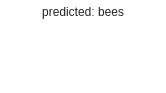

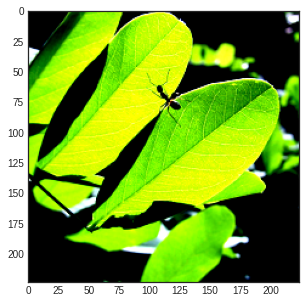

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


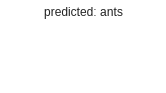

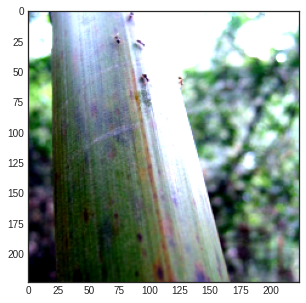

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


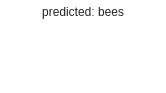

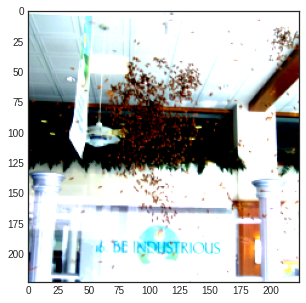

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


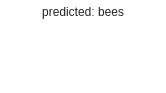

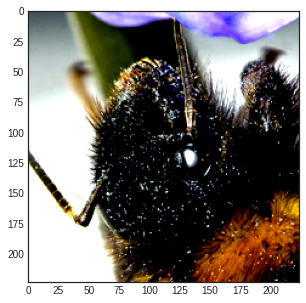

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


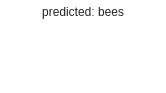

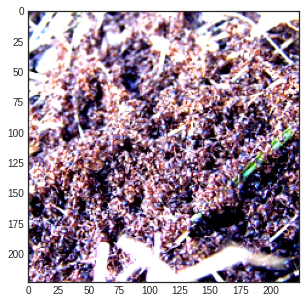

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


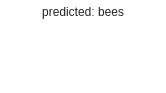

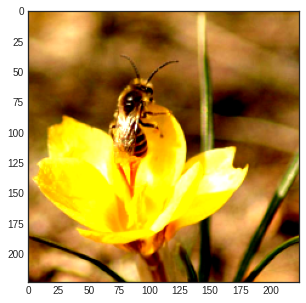

In [41]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [55]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [57]:
model_conv =train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss : 0.769296 Accuracy: 0.5246


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss : 0.770519 Accuracy: 0.5033

Epoch 1/24
----------
train Loss : 0.789568 Accuracy: 0.4508
val Loss : 0.805856 Accuracy: 0.4967

Epoch 2/24
----------
train Loss : 0.768734 Accuracy: 0.4713
val Loss : 0.803627 Accuracy: 0.4902

Epoch 3/24
----------
train Loss : 0.776385 Accuracy: 0.4795
val Loss : 0.774085 Accuracy: 0.5033

Epoch 4/24
----------
train Loss : 0.791228 Accuracy: 0.4795
val Loss : 0.775942 Accuracy: 0.4902

Epoch 5/24
----------
train Loss : 0.786287 Accuracy: 0.4836
val Loss : 0.773119 Accuracy: 0.4967

Epoch 6/24
----------
train Loss : 0.785742 Accuracy: 0.4836
val Loss : 0.802913 Accuracy: 0.5098

Epoch 7/24
----------
train Loss : 0.788416 Accuracy: 0.4713
val Loss : 0.755862 Accuracy: 0.4902

Epoch 8/24
----------
train Loss : 0.801098 Accuracy: 0.4918
val Loss : 0.783466 Accuracy: 0.5033

Epoch 9/24
----------
train Loss : 0.759788 Accuracy: 0.4795
val Loss : 0.797745 Accuracy: 0.5098

Epoch 10/24
----------
train Loss : 0.777818 Accuracy: 0.4795
val Loss 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


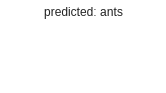

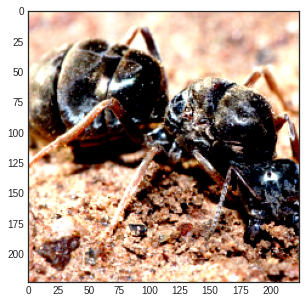

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


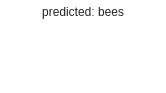

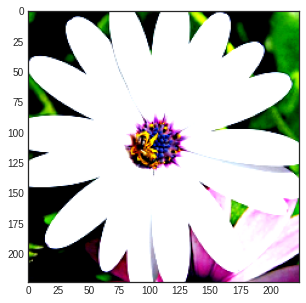

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


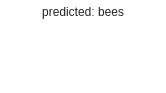

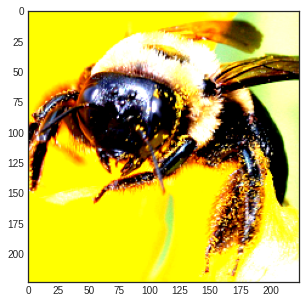

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


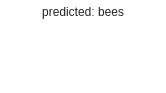

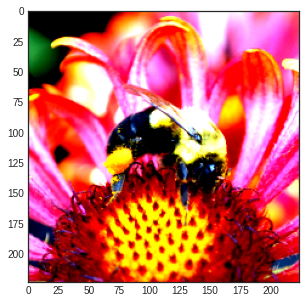

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


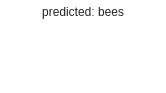

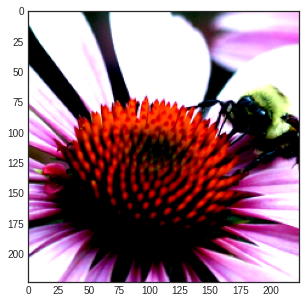

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


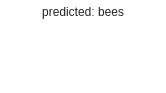

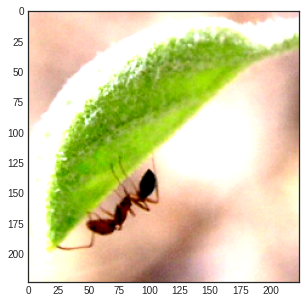

In [58]:
visualize_model(model_conv)